## Introduction

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from scipy.stats import mode
from itertools import permutations

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

np.random.seed(1234)

C:\Users\mique\AppData\Local\Temp\ipykernel_1556\2399853059.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

### Metrics 

We have a classification problem with a strong imbalance on the target class. This time we will asume equally important the missclassification errors for both classes. For this reason we are going to use the next metrics to evaluate our model:
* Accuracy. (Just for checking, accuracy is not the best metric with imbalanced data)
* Precision for all classes. 
* Recall for all classes. 
* F1-score micro average.
* F1-score macro average. 


In [3]:
def get_metrics(y_pred: NDArray, y_test: pd.core.series.Series) -> list:
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1_score_w = f1_score(y_test, y_pred, average='weighted')
    return [accuracy, recall, precision, f1_score_w]

results = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1-score weighted'])
results_test = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1-score weighted'])

# MODEL CLASSIFICATION

First of all, read the preprocessed data. It is important to be this data and not the original, because they are saved in a .csv file as it was done in the preprocessing.

In [4]:
# read clean data
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')['Severity']
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')['Severity']

### Resampling protocl

It is very important to make a good resampling protocol.

For further information, check out the report. As a resume, we have two datasets, one for training and another one for validation.

# MODELS OF DECISION TREE FAMILY

## Model 1: Decision Tree Classifier

First model we are going to take into account is a Decision Tree Classifier due to its simplicity and interpretability and the fact that it is a good starting point for more complex models. As explained detailedly in the report, we are going to use a cross validation to find the best hyperparameters for this model based on validation metric: f1-score micro.

In [5]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['sqrt', 'log2', None]

dec_tree_model = DecisionTreeClassifier(random_state=1234)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

grid_search = GridSearchCV(estimator=dec_tree_model,
                   param_grid={
                          'criterion': criterion,
                          'max_depth': max_dephts,
                          'min_samples_split': min_samples_split,
                          'min_samples_leaf': min_samples_leaf,
                          'max_features': max_features
                   },
                   scoring='f1_weighted',
                   cv=cv,
                   n_jobs=-1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1234), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [1, 2, 3, 4, 5]},
             scoring='f1_weighted')

Fit the decision tree classifier with best hyperparameters and evaluate it with the test set.

In [6]:
best_params_dec_tree = grid_search.best_params_
best_dec_tree_model = DecisionTreeClassifier(**best_params_dec_tree, random_state=1234)
best_dec_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=4, random_state=1234)

In [7]:
y_pred = cross_val_predict(best_dec_tree_model, X_train, y_train, cv=5, n_jobs=-1)

results.loc['Decision Tree'] = get_metrics(y_pred, y_train)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Decision Tree,0.819103,0.819103,0.797032,0.80447


## Model 2: Random Forest Classifier

Second model we are going to take into account is a Random Forest Classifier. This model is an ensemble of decision trees, which makes it more robust to overfitting and more accurate than a single decision tree. As explained detailedly in the report, we are going to use a cross validation to find the best hyperparameters for this model based on validation metric: f1-score weighted.

In [8]:
rf_model = RandomForestClassifier(random_state=12)

param_grid = {
    'n_estimators': [100, None],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(rf_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_rf = grid_search.best_params_

In [9]:
best_rf_model = RandomForestClassifier(**best_params_rf, random_state=1234)    
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=3, random_state=1234)

In [10]:
y_pred = cross_val_predict(best_rf_model, X_train, y_train, cv=5, n_jobs=-1)

results.loc['Random Forest'] = get_metrics(y_pred, y_train)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Random Forest,0.839107,0.839107,0.819237,0.814196
Decision Tree,0.819103,0.819103,0.797032,0.804470


## Model 3: Extra Trees Classifier

Extra Trees creates multiple highly randomized trees and averages their predictions to reduce variance. It uses random splits and the full dataset for training each tree, making it faster and robust to overfitting compared to Random Forest.

In [11]:
extra_trees_model = ExtraTreesClassifier(random_state=1234)

param_grid = {
    'n_estimators': [100, None],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(extra_trees_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_train, y_train)
best_params_extra_trees = grid_search.best_params_

In [12]:
best_extra_trees_model = ExtraTreesClassifier(**best_params_extra_trees, random_state=1234)
best_extra_trees_model.fit(X_train, y_train)

ExtraTreesClassifier(random_state=1234)

In [13]:
y_pred = cross_val_predict(best_extra_trees_model, X_train, y_train, cv=5, n_jobs=-1)

results.loc['Extra Trees'] = get_metrics(y_pred, y_train)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Random Forest,0.839107,0.839107,0.819237,0.814196
Decision Tree,0.819103,0.819103,0.797032,0.804470
Extra Trees,0.824266,0.824266,0.798212,0.793315


## Model 4: Voting Classifier

We have computed 3 models so far. Now we will take a majority vote classifier in order to see if this model is better than the other three. It will be an average from these three.

In [14]:
from sklearn.ensemble import VotingClassifier


voting_classifier = VotingClassifier(estimators=[
    ('model1', best_dec_tree_model),
    ('model2', best_rf_model),
    ('model3', best_extra_trees_model)
], voting='soft')

In [15]:
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('model1',
                              DecisionTreeClassifier(max_depth=15,
                                                     min_samples_leaf=4,
                                                     random_state=1234)),
                             ('model2',
                              RandomForestClassifier(min_samples_split=3,
                                                     random_state=1234)),
                             ('model3',
                              ExtraTreesClassifier(random_state=1234))],
                 voting='soft')

In [16]:
y_pred = cross_val_predict(voting_classifier, X_train, y_train, cv=5, n_jobs=-1)

results.loc['Voting Classifier'] = get_metrics(y_pred, y_train)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Random Forest,0.839107,0.839107,0.819237,0.814196
Voting Classifier,0.836736,0.836736,0.815269,0.813440
Decision Tree,0.819103,0.819103,0.797032,0.804470
Extra Trees,0.824266,0.824266,0.798212,0.793315


## Model 5: LOGISTIC REGRESSION

Search the optimal value of the hyperparameter C and the penalty method for the Logistic Regression model using cross validation. We are going to use the same metric as in the Random Forest Classifier: f1-score weighted.

In [17]:
logreg_model = LogisticRegression(random_state = 42)

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga']
}

grid_search = GridSearchCV(logreg_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [18]:
bes_logreg_model = LogisticRegression(**best_params, random_state=12)
bes_logreg_model.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=12, solver='saga')

In [19]:
y_pred = cross_val_predict(bes_logreg_model, X_train, y_train, cv=5, n_jobs=-1)

results.loc['Logistic Regression'] = get_metrics(y_pred, y_train)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Random Forest,0.839107,0.839107,0.819237,0.814196
Voting Classifier,0.836736,0.836736,0.815269,0.813440
Decision Tree,0.819103,0.819103,0.797032,0.804470
Extra Trees,0.824266,0.824266,0.798212,0.793315
Logistic Regression,0.800050,0.800050,0.640087,0.711185


## Model 6: QDA

This model is used to predict the class from an input feature space. The model is based on prior probabilities on the input data. It assumes they are Gaussian distributed, so it was important to normalize the data in the preprocessing.

In [20]:
#We will do a 5-fold cross-validation to find the best hyperparameters for the QDA model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
qda_model = QuadraticDiscriminantAnalysis()

param_grid = {'reg_param': [0, 0.001, 0.01, 0.1, 0.2, 0.5, 1]}

grid_search = GridSearchCV(qda_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params_qda = grid_search.best_params_
best_score_qda = grid_search.best_score_

In [21]:
best_qda_model = QuadraticDiscriminantAnalysis(**best_params_qda)
best_qda_model.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(reg_param=0.1)

In [22]:
y_pred = cross_val_predict(best_qda_model, X_train, y_train, cv=5, n_jobs=-1)

results.loc['QDA'] = get_metrics(y_pred, y_train)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Random Forest,0.839107,0.839107,0.819237,0.814196
Voting Classifier,0.836736,0.836736,0.815269,0.813440
Decision Tree,0.819103,0.819103,0.797032,0.804470
Extra Trees,0.824266,0.824266,0.798212,0.793315
QDA,0.772377,0.772377,0.779837,0.773086
Logistic Regression,0.800050,0.800050,0.640087,0.711185


## Model 7: LDA

This model is very similar to the previous one, here we will suppose that every class in Severity has the same covariance matrix.

In [23]:
param_grid = {'solver': ['lsqr', 'eigen']}
lda_model = LinearDiscriminantAnalysis()
grid_search = GridSearchCV(lda_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params_lda = grid_search.best_params_
best_score_lda = grid_search.best_score_

In [24]:
best_lda_model = LinearDiscriminantAnalysis(**best_params_lda)
best_lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis(solver='lsqr')

In [25]:
y_pred = cross_val_predict(best_lda_model, X_train, y_train, cv=5, n_jobs=-1)

results.loc['LDA'] = get_metrics(y_pred, y_train)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Random Forest,0.839107,0.839107,0.819237,0.814196
Voting Classifier,0.836736,0.836736,0.815269,0.813440
Decision Tree,0.819103,0.819103,0.797032,0.804470
Extra Trees,0.824266,0.824266,0.798212,0.793315
QDA,0.772377,0.772377,0.779837,0.773086
LDA,0.800461,0.800461,0.751742,0.760201
Logistic Regression,0.800050,0.800050,0.640087,0.711185


The results for QDA and LDA are not the same, it may be due to te fact that every class does not have the same variance-covariance matrix, that is the assumption made for doing LDA.

## Model 8: NAIVE BAYES

Categorical Naive Bayes (Categorical NB) is a simple probabilistic classifier based on Bayes' theorem with the assumption of independence between features. In the preprocessing we saw that there is not a lot of correlation between variables, so we can apply this method.

In [26]:
gaussian_nb = GaussianNB()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

grid_search = GridSearchCV(gaussian_nb, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_gaussain_nb = grid_search.best_params_

In [27]:
best_gnb_model = GaussianNB(**best_params_gaussain_nb)
best_gnb_model.fit(X_train, y_train)

GaussianNB(var_smoothing=0.0003511191734215131)

In [28]:
y_pred = cross_val_predict(best_gnb_model, X_train, y_train, cv=5, n_jobs=-1)

results.loc['GNB'] = get_metrics(y_pred, y_train)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Random Forest,0.839107,0.839107,0.819237,0.814196
Voting Classifier,0.836736,0.836736,0.815269,0.813440
Decision Tree,0.819103,0.819103,0.797032,0.804470
Extra Trees,0.824266,0.824266,0.798212,0.793315
QDA,0.772377,0.772377,0.779837,0.773086
GNB,0.765089,0.765089,0.773222,0.765268
LDA,0.800461,0.800461,0.751742,0.760201
Logistic Regression,0.800050,0.800050,0.640087,0.711185


In [29]:
# categorical variables
categorical_cols = ['Year','Month','Day','Hour','Weekday']

X_train_cat = X_train[categorical_cols]
X_train_num = X_train.drop(categorical_cols, axis=1)

In [30]:
gaussian_nb = GaussianNB()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

grid_search = GridSearchCV(gaussian_nb, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_num, y_train)
best_params_gaussain_nb_num = grid_search.best_params_

best_gnb_model = GaussianNB(**best_params_gaussain_nb_num)
best_gnb_model.fit(X_train_num, y_train)

# categorical GNB
cat_gaussian_nb = CategoricalNB()

param_grid_cat = {
    'alpha': np.logspace(0,-9, num=100)
}

grid_search = GridSearchCV(cat_gaussian_nb, param_grid = param_grid_cat, cv = cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_cat, y_train)
best_params_gaussain_nb_cat = grid_search.best_params_

best_cat_gnb_model = CategoricalNB(**best_params_gaussain_nb_cat)
best_cat_gnb_model.fit(X_train_cat, y_train)

combined_prediction_proba = np.concatenate((best_cat_gnb_model.predict_proba(X_train_cat), best_gnb_model.predict_proba(X_train_num)), axis=1)

In [31]:
y_pred_num = cross_val_predict(best_gnb_model, X_train_num, y_train, cv=5, n_jobs=-1)
results.loc['GNB numerical'] = get_metrics(y_pred_num, y_train)

y_pred_cat = cross_val_predict(best_cat_gnb_model, X_train_cat, y_train, cv=5, n_jobs=-1)
results.loc['GNB categorical'] = get_metrics(y_pred_cat, y_train)

combined_predictions = np.vstack((y_pred_num, y_pred_cat)).T


y_pred_combined = mode(combined_predictions, axis=1)[0].flatten()

results.loc['GNB combined'] = get_metrics(y_pred_combined, y_train)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Random Forest,0.839107,0.839107,0.819237,0.814196
Voting Classifier,0.836736,0.836736,0.815269,0.813440
Decision Tree,0.819103,0.819103,0.797032,0.804470
Extra Trees,0.824266,0.824266,0.798212,0.793315
QDA,0.772377,0.772377,0.779837,0.773086
GNB,0.765089,0.765089,0.773222,0.765268
LDA,0.800461,0.800461,0.751742,0.760201
GNB numerical,0.764451,0.764451,0.741136,0.748999
GNB combined,0.800026,0.800026,0.643670,0.711274
GNB categorical,0.800055,0.800055,0.640088,0.711187


As we see this models does not fit well the data. This could be due to we supposed variables were uncorrelated, but in fact they are. Thus there exists dependece between variables, and this method cannot be applied.

## Model 9: $k$-NN

This methods predicts the actual sample by using similar properties from the k nearest neighbours. Each new sample will go to the class with the most similar values from the train set. 

In [32]:
param_grid = {'n_neighbors': [1, 3, 10, 20], 'metric': ['euclidean', 'minkowski', 'manhattan']}
knn_model = KNeighborsClassifier()
grid_search = GridSearchCV(knn_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params_knn = grid_search.best_params_

In [33]:
best_knn_model = KNeighborsClassifier(**best_params_knn)
best_knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3)

In [34]:
y_pred = cross_val_predict(best_knn_model, X_train, y_train, cv=5, n_jobs=-1)

results.loc['KNN'] = get_metrics(y_pred, y_train)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Random Forest,0.839107,0.839107,0.819237,0.814196
Voting Classifier,0.836736,0.836736,0.815269,0.813440
Decision Tree,0.819103,0.819103,0.797032,0.804470
Extra Trees,0.824266,0.824266,0.798212,0.793315
QDA,0.772377,0.772377,0.779837,0.773086
KNN,0.786571,0.786571,0.758315,0.768350
GNB,0.765089,0.765089,0.773222,0.765268
LDA,0.800461,0.800461,0.751742,0.760201
GNB numerical,0.764451,0.764451,0.741136,0.748999
GNB combined,0.800026,0.800026,0.643670,0.711274


## Model 10: Clustering

Finally, we will apply clustering with 4 clusters, the same number of classes at Severity. It is a great method to agroup data. We will aply two methods, k-Means and EM.

### Model 10.1: $k$-Means

In [35]:
param_grid = {'n_clusters': [4], 'init':['kmeans++','random']}
kmeans_model = KMeans()
grid_search = GridSearchCV(kmeans_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_kmeans = grid_search.best_params_

In [36]:
best_kmeans_model = KMeans(**best_params_kmeans, random_state=1234)
best_kmeans_model.fit(X_train, y_train)

KMeans(init='random', n_clusters=4, random_state=1234)

In order to calculate the metrics we will use an exhaustive search approach. So we can compare these non-labelled methods with the others.

In [37]:
y_pred = cross_val_predict(best_kmeans_model, X_train, y_train, cv=5, n_jobs=-1)

K = 4
nombres = list(range(1,K+1))
label_combinations = list(permutations(nombres))

best_score = None
best_combination_knn = None

for combination in label_combinations:
    y_pred_comb = [combination[y] for y in y_pred]
    metric = get_metrics(y_pred_comb, y_train)
    if best_score is None or metric[3] > best_score:
        best_score = metric[3]
        best_combination_knn = combination


results.loc['K-Means'] = best_score
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Random Forest,0.839107,0.839107,0.819237,0.814196
Voting Classifier,0.836736,0.836736,0.815269,0.813440
Decision Tree,0.819103,0.819103,0.797032,0.804470
Extra Trees,0.824266,0.824266,0.798212,0.793315
QDA,0.772377,0.772377,0.779837,0.773086
KNN,0.786571,0.786571,0.758315,0.768350
GNB,0.765089,0.765089,0.773222,0.765268
LDA,0.800461,0.800461,0.751742,0.760201
GNB numerical,0.764451,0.764451,0.741136,0.748999
GNB combined,0.800026,0.800026,0.643670,0.711274


### Model 10.2: EM

In [38]:
param_grid = {'n_components': [4], 'init_params':['kmeans','random']}
em_model = GaussianMixture()
grid_search = GridSearchCV(em_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_em = grid_search.best_params_

In [39]:
best_em_model = GaussianMixture(**best_params_em, random_state=1234)
best_em_model.fit(X_train, y_train)

GaussianMixture(n_components=4, random_state=1234)

In [40]:
y_pred = cross_val_predict(best_em_model, X_train, y_train, cv=5, n_jobs=-1)

K = 4
nombres = list(range(1,K+1))
label_combinations = list(permutations(nombres))

best_score = None
best_combination_knn = None

for combination in label_combinations:
    y_pred_comb = [combination[y] for y in y_pred]
    metric = get_metrics(y_pred_comb, y_train)
    if best_score is None or metric[3] > best_score:
        best_score = metric[3]
        best_combination_knn = combination


results.loc['EM'] = best_score
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Random Forest,0.839107,0.839107,0.819237,0.814196
Voting Classifier,0.836736,0.836736,0.815269,0.813440
Decision Tree,0.819103,0.819103,0.797032,0.804470
Extra Trees,0.824266,0.824266,0.798212,0.793315
QDA,0.772377,0.772377,0.779837,0.773086
KNN,0.786571,0.786571,0.758315,0.768350
GNB,0.765089,0.765089,0.773222,0.765268
LDA,0.800461,0.800461,0.751742,0.760201
GNB numerical,0.764451,0.764451,0.741136,0.748999
GNB combined,0.800026,0.800026,0.643670,0.711274


## Testing best models with the test set

### Decision Tree Classifier

In [41]:
# best_dec_tree_model
y_pred = best_dec_tree_model.predict(X_test)
results_test.loc['Decision Tree'] = get_metrics(y_pred, y_test)
results_test.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Decision Tree,0.822398,0.822398,0.800692,0.807842


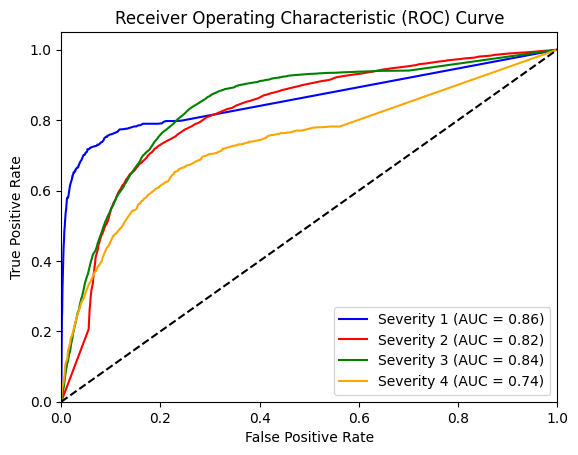

In [42]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get the predicted probabilities for each class
y_pred_proba = best_dec_tree_model.predict_proba(X_test)

# Compute ROC curve and ROC AUC for each class
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test == i+1, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for i in range(4):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='Severity {} (AUC = {:.2f})'.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

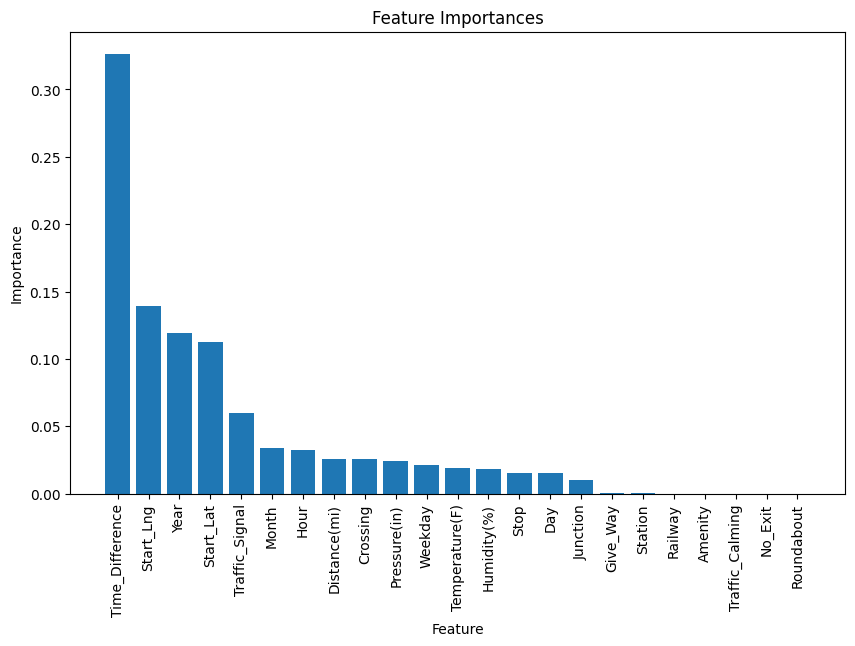

In [43]:
feature_importances = best_dec_tree_model.feature_importances_

# Create a dataframe to store the feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the dataframe by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

### Random Forest Classifier

In [44]:
y_pred = best_rf_model.predict(X_test)
results_test.loc['Random Forest'] = get_metrics(y_pred, y_test)
results_test.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Decision Tree,0.822398,0.822398,0.800692,0.807842
Random Forest,0.836449,0.836449,0.817707,0.805207


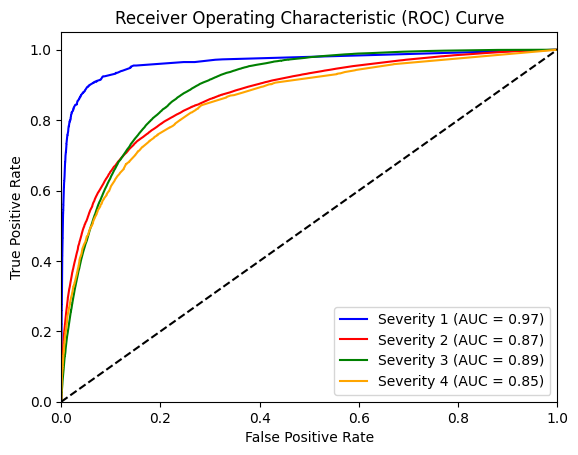

In [45]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get the predicted probabilities for each class
y_pred_proba = best_rf_model.predict_proba(X_test)

# Compute ROC curve and ROC AUC for each class
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test == i+1, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for i in range(4):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='Severity {} (AUC = {:.2f})'.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


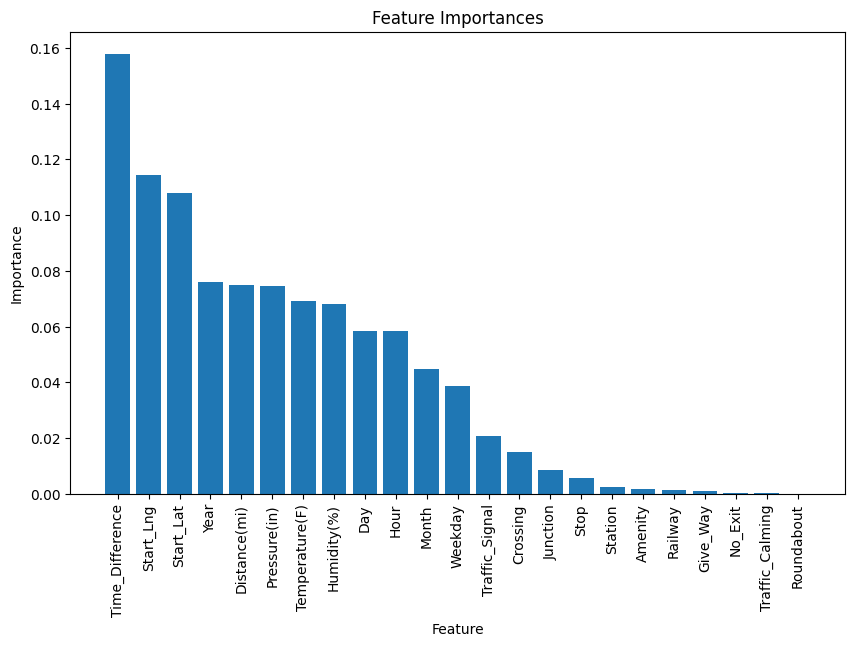

In [46]:
feature_importances = best_rf_model.feature_importances_

# Create a dataframe to store the feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the dataframe by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

### Voting Classifier

In [47]:
y_pred = voting_classifier.predict(X_test)
results_test.loc['Voting Classifier'] = get_metrics(y_pred, y_test)
results_test.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted
Voting Classifier,0.837592,0.837592,0.816713,0.811317
Decision Tree,0.822398,0.822398,0.800692,0.807842
Random Forest,0.836449,0.836449,0.817707,0.805207


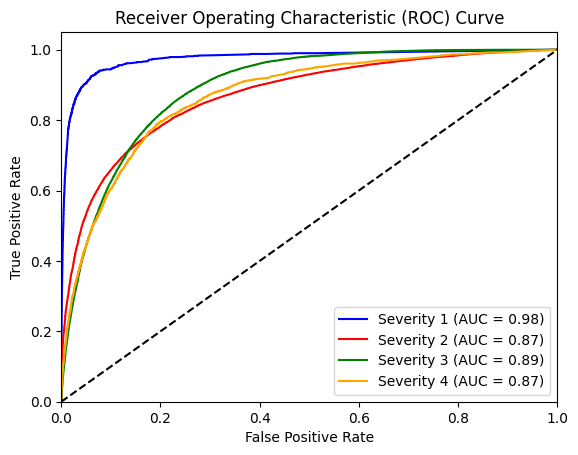

In [48]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get the predicted probabilities for each class
y_pred_proba = voting_classifier.predict_proba(X_test)

# Compute ROC curve and ROC AUC for each class
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test == i+1, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for i in range(4):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='Severity {} (AUC = {:.2f})'.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
feature_importances = voting_classifier.feature_importances_

# Create a dataframe to store the feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the dataframe by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()